In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d

In [2]:
TIME_STEP = 1/1000

In [3]:
class Plant:
    
    def __init__(self, noise_scale=0, noise_decay=0, noise_momentum=0.5):
        self.__x = 0
        self.__y = 0
        self.__z = 0
        self.__vx = 0
        self.__vy = 0
        self.__vz = 0
        self.__noise_scale = noise_scale
        self.__noise_decay = noise_decay
        self.__noise_momentum = noise_momentum
        self.noise = np.zeros(3)
    
    def step(self, ax, ay, az):
        noise = np.random.randn(3) * self.__noise_scale
        self.noise = \
            self.__noise_momentum*self.noise + \
            (1-self.__noise_momentum)*noise
        self.noise *= 1-self.__noise_decay
        ax += self.noise[0]
        ay += self.noise[1]
        az += self.noise[2]
        self.__x += self.__vx*TIME_STEP + 0.5*ax*TIME_STEP**2
        self.__y += self.__vy*TIME_STEP + 0.5*ay*TIME_STEP**2
        self.__z += self.__vz*TIME_STEP + 0.5*az*TIME_STEP**2
        self.__vx += ax*TIME_STEP
        self.__vy += ay*TIME_STEP
        self.__vz += az*TIME_STEP
        return self.__x, self.__y, self.__z

In [4]:
class PIDController:
    
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.disable_integral = False
        self.ierr = 0
        self.__prev_err = 0
    
    def step(self, measured, desired):
        err = desired - measured
        self.ierr = 0 if self.disable_integral else self.ierr + err*TIME_STEP
        derr = (err-self.__prev_err)/TIME_STEP
        self.__prev_err = err
        return self.Kp*err + self.Ki*self.ierr + self.Kd*derr

In [5]:
class Target:
    
    def __init__(self, scale=1, momentum=0.5):
        self.__plant = Plant(noise_scale=0)
        self.__scale = scale
        self.__momentum = momentum
        self.__a = np.zeros((3,))
    
    def step(self):
        self.__a = self.__a*self.__momentum + \
            (1-self.__momentum)*np.random.randn(3)
        return self.__plant.step(*self.__a*self.__scale)

final noise -1.526069693856674 -0.30532976318959937 -2.4695040140258895
final ierr 0.105084850574542 -0.013933372813480489 0.03392650241127438
final err 0.06925631092628493 0.2420044213700976 0.057007956876091725


<IPython.core.display.Javascript object>


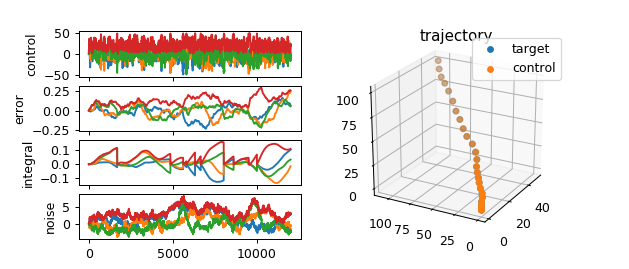

In [6]:
Kp,Ki,Kd = 10,100,35
control_max = 50
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
pid_x, pid_y, pid_z = [PIDController(Kp,Ki,Kd) for _ in range(3)]
x,y,z = plant.step(0,0,0)
T, Y, C, E, I, N = [[] for _ in range(6)]
for t in range(12000):
    tx,ty,tz = target.step()
    cx = pid_x.step(x,tx)
    cy = pid_y.step(y,ty)
    cz = pid_z.step(z,tz)
    clen = np.linalg.norm((cx,cy,cz))
    pid_x.disable_integral = \
    pid_y.disable_integral = \
    pid_z.disable_integral = clen > control_max
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((tx-x,ty-y,tz-z,np.linalg.norm((tx-x,ty-y,tz-z))))
    I.append((pid_x.ierr,pid_y.ierr,pid_z.ierr,np.linalg.norm((pid_x.ierr,pid_y.ierr,pid_z.ierr))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', tx-x, ty-y, tz-z)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::500],0,-1)); ax.scatter(*np.moveaxis(Y[::500],0,-1))
plt.legend(['target', 'control'])
plt.subplot(421); plt.ylabel('control'); plt.plot(C)
plt.subplot(423); plt.ylabel('error'); plt.plot(E)
plt.subplot(425); plt.ylabel('integral'); plt.plot(I)
plt.subplot(427); plt.ylabel('noise'); plt.plot(N)
plt.show()

In [6]:
import keras
import keras.backend as K

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
class PIDCell(keras.layers.Layer):
    
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units)
        super(PIDCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.built = True
    
    def call(self, inputs, states):
        dt, err, Kp, Ki, Kd, reset_integral = \
            inputs[:,0:1],inputs[:,1:self.units+1], \
            inputs[:,self.units+1:self.units+2],inputs[:,self.units+2:self.units+3], \
            inputs[:,self.units+3:self.units+4],inputs[:,self.units+4:self.units+5]
        perr, ierr = states
        ierr = (1-K.sigmoid(reset_integral))*(ierr+err*dt)
        derr = (err-perr)/dt
        perr = err
        return K.relu(Kp)*err + K.relu(Ki)*ierr + K.relu(Kd)*derr, [perr, ierr]

In [10]:
X_input_dt = keras.layers.Input((None, 1), batch_shape=(1,1,1))
X_input_err = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.LSTM(32, stateful=True, return_sequences=True, activation='relu', kernel_initializer='he_normal')(X_input_err)
X_Kp = keras.layers.LSTM(1, stateful=True, return_sequences=True, activation=None)(X)
X_Ki = keras.layers.LSTM(1, stateful=True, return_sequences=True, activation=None)(X)
X_Kd = keras.layers.LSTM(1, stateful=True, return_sequences=True, activation=None)(X)
X_reset_integral = keras.layers.LSTM(1, stateful=True, return_sequences=True, activation=None)(X)
X = keras.layers.Concatenate()([X_input_dt,X_input_err,X_Kp,X_Ki,X_Kd,X_reset_integral])
X_pid = keras.layers.RNN(PIDCell(3), stateful=True, return_sequences=True)(X)
M_control = keras.Model([X_input_dt,X_input_err], X_pid)
M_control.compile('adam', 'mse')
M_control.summary()

X_input_err = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X_input_ctl = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.Concatenate()([X_input_err, X_input_ctl])
X = keras.layers.LSTM(32, stateful=True, return_sequences=True, activation='relu', kernel_initializer='he_normal')(X)
X = keras.layers.LSTM(3, stateful=True, return_sequences=True, activation=None)(X)
M_plant = keras.Model([X_input_err,X_input_ctl], X)
M_plant.compile('adam', 'mse')
M_plant_freeze = keras.Model([X_input_err,X_input_ctl], X)
M_plant_freeze.trainable = False
M_plant_freeze.compile('adam', 'mse')
M_plant.summary()

X_input_dt = keras.layers.Input((None, 1), batch_shape=(1,1,1))
X_input_err = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = M_control([X_input_dt,X_input_err])
X = M_plant_freeze([X_input_err,X])
M_train = keras.Model([X_input_dt,X_input_err], X)
M_train.compile('adam', 'mse')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (1, 1, 3)            0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (1, 1, 32)           4608        input_8[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (1, 1, 1)            0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (1, 1, 1)            136         lstm_8[0][0]                     
__________________________________________________________________________________________________
lstm_10 (L

In [11]:
control_max = 50
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
x,y,z = plant.step(0,0,0)
ex,ey,ez = 0,0,0
T, Y, C, E, N = [[] for _ in range(5)]
M_control.reset_states()
for t in range(1000):
    tx,ty,tz = target.step()
    cx,cy,cz = M_control.predict([
        np.array([[[TIME_STEP]]]),
        np.array([[[ex,ey,ez]]])])[0][0,0]
    clen = np.linalg.norm((cx,cy,cz))
    pid_x.disable_integral = \
    pid_y.disable_integral = \
    pid_z.disable_integral = clen > control_max
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    ex,ey,ez = tx-x,ty-y,tz-z
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((ex,ey,ez,np.linalg.norm((ex,ey,ez))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
print('final noise', *plant.noise)
#print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', ex, ey, ez)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::50],0,-1)); ax.scatter(*np.moveaxis(Y[::50],0,-1))
plt.legend(['target', 'control'])
plt.subplot(421); plt.ylabel('control'); plt.plot(C)
plt.subplot(423); plt.ylabel('error'); plt.plot(E)
#plt.subplot(425); plt.ylabel('integral'); plt.plot(I)
plt.subplot(427); plt.ylabel('noise'); plt.plot(N)
plt.show()

M_plant.reset_states()
for e,c,l in zip(E[:-1], C[1:], E[1:]):
    M_plant.fit([[[e[:3]]],[[c[:3]]]], [[l[:3]]], shuffle=False, verbose=0)

InvalidArgumentError: You must feed a value for placeholder tensor 'input_11' with dtype float and shape [1,1,1]
	 [[Node: input_11 = Placeholder[dtype=DT_FLOAT, shape=[1,1,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: rnn_2/transpose_1/_339 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2092_rnn_2/transpose_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_11', defined at:
  File "/usr/lib64/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib64/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib64/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/lib64/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/lib64/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-7cf6e1aa3b91>", line 26, in <module>
    X_input_dt = keras.layers.Input((None, 1), batch_shape=(1,1,1))
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/keras/engine/topology.py", line 1457, in Input
    input_tensor=tensor)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/keras/engine/topology.py", line 1366, in __init__
    name=self.name)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 507, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1746, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3051, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_11' with dtype float and shape [1,1,1]
	 [[Node: input_11 = Placeholder[dtype=DT_FLOAT, shape=[1,1,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: rnn_2/transpose_1/_339 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2092_rnn_2/transpose_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
